# FVI Clustering

This notebook filters frames based on FVI scores, creates embeddings for the selected frames, and clusters the embeddings.

In [17]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import random


# Add the path to the scripts directory
import sys
sys.path.append('../scripts')
print(np.__version__)

1.26.4


## Load FVI Scores

Load the FVI scores from the `fvi_scores.json` file.

In [18]:
def load_fvi_scores(directory):
    fvi_scores = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'fvi_scores.json':
                filepath = os.path.join(root, file)
                with open(filepath, 'r') as f:
                    scores = json.load(f)
                    fvi_scores[root] = scores
    return fvi_scores

fvi_scores = load_fvi_scores('../output/fvi_computation')

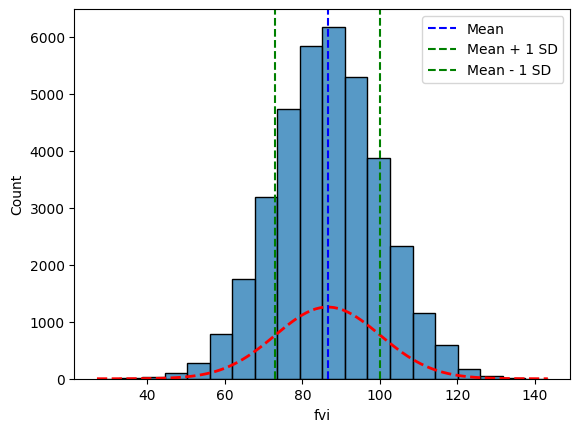

In [19]:
# create a chart to show the distribution of the fvi scores
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm

# Example fvi_scores dictionary for demonstration purposes
fvi_scores_list = []
for root, scores in fvi_scores.items():
    for score in scores:
        fvi_scores_list.append(score)

df = pd.DataFrame(fvi_scores_list, columns=['fvi'])

sns.histplot(df, x='fvi', bins=20)

# add a bell curve
mu, std = norm.fit(df['fvi'])
min_fvi, max_fvi = df['fvi'].min(), df['fvi'].max()
x = np.linspace(min_fvi, max_fvi, 100)
y = norm.pdf(x, mu, std) * len(df) * (x[1] - x[0])
plt.plot(x, y, 'r--', linewidth=2)

# Add standard deviation lines
plt.axvline(mu, color='blue', linestyle='--', label='Mean')
plt.axvline(mu + std, color='green', linestyle='--', label='Mean + 1 SD')
plt.axvline(mu - std, color='green', linestyle='--', label='Mean - 1 SD')
plt.legend()

plt.show()

## Filter Frames

Filter frames with FVI scores above a certain threshold.
low FVI scores => redundant

In [30]:
threshold = 120 # optimal threshold value not neglecting important frames
selected_frames_images = []
frame_ground_truth = []
for directory, scores in fvi_scores.items():
    for i, score in enumerate(scores):
        if score > threshold:
            directory = directory.replace("\\", "/")

            # Adjusting the directory path to replace "../output/ground_truth" with "/data"
            print(directory)
            adjusted_directory = directory.replace("../output/fvi_computation", "../data/ground_truth")
            adjusted_directory_image = directory.replace("../output/fvi_computation", "../output/video_frames")

            # Adjusting the directory path to replace "/preds" with ""
            adjusted_directory_image = adjusted_directory_image.replace("preds", "")
            print(adjusted_directory)

            ground_truth_path = os.path.join(adjusted_directory, f'{i+1:04d}.json')
            image_path = os.path.join(adjusted_directory_image, f'{i+1:04d}.jpg')
            image_path = image_path.replace("\\", "/")
            frame_path = frame_path.replace("\\", "/")
            selected_frames_images.append(image_path)
            frame_ground_truth.append(ground_truth_path)

print(len(selected_frames))
print(frame_ground_truth[:5])
print(selected_frames_images[:5])

../output/fvi_computation/408/VID002A/preds
../data/ground_truth/408/VID002A/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../output/fvi_computation/408/VID002B/preds
../data/ground_truth/408/VID002B/preds
../o

In [31]:
sys.path.append('../scripts')

from coco_converter import convert_selected_frames_to_coco

print(frame_ground_truth[:5]) # selected frame is actually the json groundtruth file.
convert_selected_frames_to_coco(frame_ground_truth, '../output/selected_frames_coco.json')

['../data/ground_truth/408/VID002A/preds/1957.json', '../data/ground_truth/408/VID002B/preds/1668.json', '../data/ground_truth/408/VID002B/preds/1728.json', '../data/ground_truth/408/VID002B/preds/1809.json', '../data/ground_truth/408/VID002B/preds/1816.json']
COCO file created at: ../output/selected_frames_coco.json


## Create Embeddings

Use a pre-trained ResNet model from PyTorch to create embeddings for the selected frames.

In [32]:
import torch
print(torch.cuda.is_available()) # run nvidia-smi to check if GPU is available

True


In [33]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import fiftyone as fo
import fiftyone.brain as fob
from sklearn.cluster import KMeans

sys.path.append('../scripts')

from embeddings_generator import process_image, generate_embeddings
from coco_converter import convert_selected_images_to_coco

# Generate Embeddings 

In [34]:
image_paths = selected_frames_images
# Generate embeddings for all images
embeddings = generate_embeddings(image_paths)
valid_embeddings = [embedding for embedding in embeddings if embedding is not None]  # Filter out None values in case error

# Find the optimal # of Clusters

In [ ]:
from kneed import KneeLocator

# inertia 
k_values = range(1, 100)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(valid_embeddings)
    inertia_values.append(kmeans.inertia_)
    

knee_locator = KneeLocator(k_values, inertia_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.axvline(optimal_k, color='red', linestyle='--', label='Optimal k')
plt.legend()
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show()
print(f"Optimal number of clusters: {optimal_k}")


# Use the optimal number of clusters and for each cluster, calculate the centroid. Then get "m" many sample points per each cluster.

In [ ]:
n_clusters = optimal_k  # of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
cluster_labels = kmeans.fit_predict(valid_embeddings)
clusters = kmeans.labels_

cluster_dict = []
for idx, cluster in enumerate(cluster_labels):
    cluster_dict.append({"cluster": cluster, "embedding": valid_embeddings[idx], "file_path": image_paths[idx]})

centroids = kmeans.cluster_centers_
m = 2 # of items to sample from each cluster that is closest to the centroid

# The sampled points that we want
closest_points = {}

for cluster_id, centroid in enumerate(centroids):
    distances = np.linalg.norm(embeddings - centroid, axis=1)
    closest_indices = np.argsort(distances)[:m]
    closest_points[cluster_id] = closest_indices
    

# Find the closest images to each centroid
representatives = []  # List to store representative images for each cluster

# Iterate over each cluster and find the closest points
for cluster_id, centroid in enumerate(centroids):
    # Compute distances from all valid embeddings to the centroid
    distances = np.linalg.norm(np.array(valid_embeddings) - centroid, axis=1)
    
    # Get indices of the closest images (m closest points)
    closest_indices = np.argsort(distances)[:m]
    
    # Create a dictionary for this cluster with image paths and embeddings
    cluster_representative = {
        "cluster": cluster_id,
        # "centroid": centroid.tolist(),  # Convert centroid to list for better readability
        "closest_images": [
            {
                "file_path": image_paths[idx],
                # "embedding": valid_embeddings[idx].tolist()  # Convert embedding to list
            }
            for idx in closest_indices
        ]
    }
    
    representatives.append(cluster_representative)


selected_representatives_images = [] # get the actual image paths
for rep in representatives:
    for path in rep["closest_images"]:
        selected_representatives_images.append(path['file_path'])

print(f"Number of selected representative images: {len(selected_representatives_images)}")

# Convert list to a dictionary with keys and values being the same
my_dict = {item: item for item in selected_representatives_images}

# Write the dictionary to a JSON file
with open('../output/selected_representatives_image.json', 'w') as json_file:
    json.dump(my_dict, json_file)

# Convert the selected representative images to COCO format
convert_selected_images_to_coco(selected_representatives_images, '../output/selected_representatives_coco.json')

# Export Filtered Coco File and Images from Dataset 

In [ ]:
import fiftyone as fo
import fiftyone.brain as fob


from coco_converter import categories # import coco categories for detection

# Define the directory where you want to export the dataset
export_dir = "../output/selected_representatives_dataset"

# dataset_rest = fo.Dataset.from_images(selected_frames_images)
dataset = fo.Dataset.from_dir(
    data_path="../output/selected_representatives_image.json",
    labels_path="../output/selected_representatives_coco.json",
    dataset_type=fo.types.COCODetectionDataset,
)


# Export the dataset to COCO format
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.COCODetectionDataset,
    categories=categories
)

# Export the dataset to the specified directory
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.ImageDirectory
)


# View filtered dataset

In [ ]:
# View the dataset in Fiftyone and visualize the data + embeddings
fob.compute_visualization(
    dataset,
    embeddings="resnet101",
    method="umap",
    brain_key="umap_resnet101",
    patches_field="detections"
)

session = fo.launch_app(dataset)
session.wait()